# Regression

We use the same network architecture as the classification one, with the only difference that the last layer has now two output neurons (corresponding to the chirp mass and mass ratio predictions). The loss function is now the mean squared error, and we perform early stopping on the validation loss.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

import numpy as np 
from class_functions import *
import pandas as pd
import sklearn

np.random.seed(1234)
root_dir = "/home/alberto_sinigaglia/gaia"

In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1762164220.564705  307366 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 44478 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:41:00.0, compute capability: 8.6


In [3]:
def basic_block(x, kernel_size, filters, reg_rate, name, pool_size=2):
    """Single Conv1D layer with ReLU activation + global avarage pooling"""

    x = tf.keras.layers.Conv1D(filters, kernel_size, padding='same', activation=None, kernel_regularizer=tf.keras.regularizers.l2(reg_rate), name=f'{name}_conv')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1, name=f"{name}_leaky_relu")(x)
    x = tf.keras.layers.Dropout(0.3, name=f'{name}_dropout')(x)
    x = tf.keras.layers.AveragePooling1D(pool_size,  name=f'{name}_avgpooling')(x)
    return x
    
def residual_block(x, kernel_size, filters, reg_rate, name):

    shortcut = x 
    x = tf.keras.layers.Conv1D(filters, kernel_size, padding='same', activation=None, kernel_regularizer=tf.keras.regularizers.l2(reg_rate), name=f'{name}_conv1')(x)
    x = tf.keras.layers.BatchNormalization(name=f'{name}_bn1')(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1, name=f"{name}_leaky_relu1")(x)
    x = tf.keras.layers.Conv1D(filters, kernel_size, padding='same', activation=None,  kernel_regularizer=tf.keras.regularizers.l2(reg_rate), name=f'{name}_conv2')(x)
    x = tf.keras.layers.BatchNormalization(name=f'{name}_bn2')(x)
    x = tf.keras.layers.Add( name=f'{name}_add')([shortcut, x])
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1, name=f"{name}_leaky_relu2")(x)
    return x

def build_model(reg_rate, drop_rate, input_length=6144, channels=1, filters=42):

    inp = tf.keras.layers.Input(shape=(input_length, channels), name='input_layer')

    x = basic_block(inp, 16, filters, reg_rate, name='bb_1')
    x = residual_block(x, 16, filters, reg_rate, name='rb_1')

    x = basic_block(x, 32, filters, reg_rate, name='bb_2')
    x = residual_block(x, 32, filters, reg_rate, name='rb_2')

    x = basic_block(x, 64, filters, reg_rate, name='bb_3')
    x =  residual_block(x, 64, filters, reg_rate, name='rb_3')

    x = basic_block(x, 64, filters, reg_rate, name='bb_4')

    #x = tf.keras.layers.Flatten(name='flatten_layer')(x)
    x = tf.keras.layers.GlobalAveragePooling1D(name='global_avg_pool')(x)

    #x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4), name='dl_1')(x)
    #x = tf.keras.layers.Dropout(0.2, name='dropout_1')(x)
    #x = tf.keras.layers.Dense(64,  activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4), name='dl_2')(x)
    #x = tf.keras.layers.Dropout(0.3, name='dropout_2')(x)
    x = tf.keras.layers.Dense(64,  activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_rate), name='dl_3')(x)
    x = tf.keras.layers.Dropout(drop_rate, name='dropout_1')(x)
    x = tf.keras.layers.Dense(32,  activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_rate), name='dl_4')(x)
    x = tf.keras.layers.Dropout(drop_rate, name='dropout_2')(x)

    out = tf.keras.layers.Dense(2, activation='linear', name='output_layer')(x)

    model =  tf.keras.Model(inp, out, name='regression_model')
    return model

The procedure followed will be the same for all the different mass ranges:
1. We load the data, filtering only the timeseries corresponding to GW events 
2. We build a tf dataset
3. We fit the model 
4. We plot the training-loss validation curves 
5. We plot the predicted vs true chirp mass 
6. We plot the predicted vs true mass ratio 

## Low mass

In [4]:
mass_range = "CNN_low_mass"

train_path = f"{root_dir}/{mass_range}_train.npz"
test_path = f"{root_dir}/{mass_range}_test.npz"

# load the data 
with np.load(train_path, allow_pickle=True) as data:
    X = data["X"]
    y = data["y"]

mask = y[:,0] == 1 
X, y= X[mask], y[mask]

X_train, X_val, y_train, y_val = split_train_val(X, y, val_size=0.2)

with np.load(test_path, allow_pickle=True) as data:
    X_test = data["X"]
    y_test = data["y"]

mask = y_test[:,0] == 1
X_test, y_test= X_test[mask], y_test[mask]

# create the dataset 
batch_size = 64

train_dataset, train_scaler = make_dataset(X_train, y_train, classification=False, batch_size=batch_size)
val_dataset, val_scaler = make_dataset(X_val, y_val, classification=False, batch_size=batch_size)
test_dataset, test_scaler = make_dataset(X_test, y_test, classification=False, batch_size=batch_size, shuffle=False)

In [6]:
model = build_model(reg_rate=5e-4, drop_rate=0.3)

total_steps = 5808 // 128 * 150  # Assuming 5808 training samples, batch size 64, for 50 epochs
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=5e-5,
    decay_steps=total_steps,
    alpha=1e-6
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=5.0), 
              loss=tf.keras.losses.MeanSquaredError(),               
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

/home/alberto_sinigaglia/anaconda3/envs/gaia/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [5]:
model_path = f"reg_models/{mass_range}_best_model.keras"
logger_path = f"reg_models/training_log_{mass_range}.csv"

'''
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=model_path, 
        monitor="val_loss",
        mode="min",
        save_best_only=True,
        verbose=1,
    ),
    
    tf.keras.callbacks.CSVLogger(
        filename=logger_path,
        append=False,
    )
]

history = model.fit(
    x=train_dataset,
    validation_data=val_dataset,
    epochs=150,
    callbacks=callbacks,
    verbose=1,
)
'''

'\ncallbacks = [\n    tf.keras.callbacks.ModelCheckpoint(\n        filepath=model_path, \n        monitor="val_loss",\n        mode="min",\n        save_best_only=True,\n        verbose=1,\n    ),\n    \n    tf.keras.callbacks.CSVLogger(\n        filename=logger_path,\n        append=False,\n    )\n]\n\nhistory = model.fit(\n    x=train_dataset,\n    validation_data=val_dataset,\n    epochs=150,\n    callbacks=callbacks,\n    verbose=1,\n)\n'

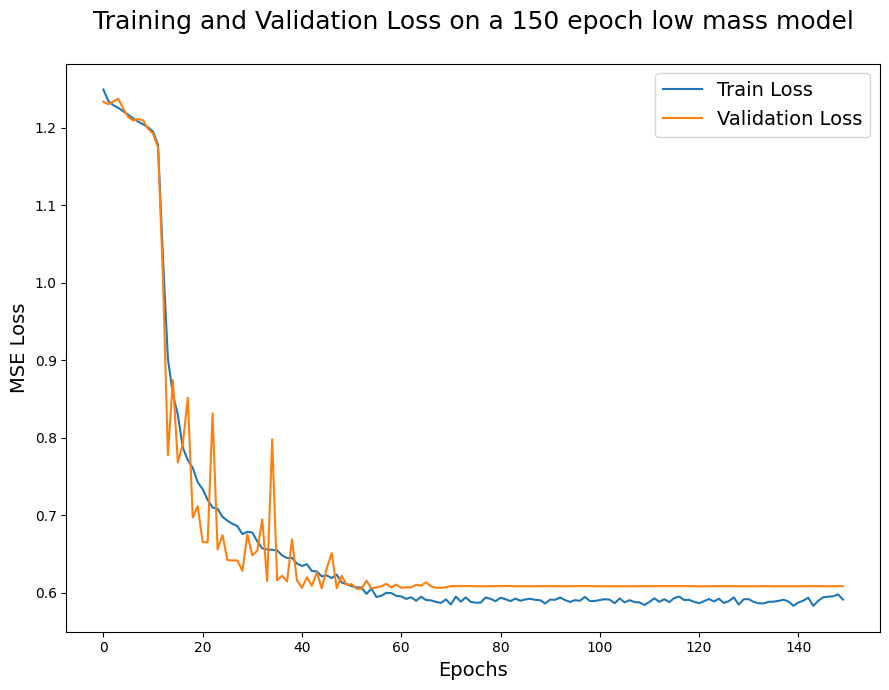

In [8]:
logger = pd.read_csv(logger_path)
train_loss = logger['loss'].values
val_loss = logger['val_loss'].values

plt.figure(figsize=(9,7))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('MSE Loss', fontsize=14)

plt.title('Training and Validation Loss on a 150 epoch low mass model',
          fontsize=18, pad=25)

plt.legend(fontsize=14, loc='best')

plt.tight_layout()
plt.show()

In [7]:
model = tf.keras.models.load_model(model_path)
mse, rmse = model.evaluate(test_dataset)
y_pred = model.predict(X_test)
y_pred = test_scaler.inverse_transform(y_pred)

true_M = y_test[:,1].astype(np.float64)
pred_M = y_pred[:,0]
rmse_M = np.sqrt(np.mean((pred_M - true_M)**2))

true_q = y_test[:,2].astype(np.float64)
pred_q = y_pred[:,1]
rmse_q = np.sqrt(np.mean((pred_q - true_q)**2))

print(f"Test chirp mass RMSE: {rmse_M} \n Test mass ratio RMSE: {rmse_q}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.6006 - rmse: 0.6589
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
Test chirp mass RMSE: 1.6268046516823176 
 Test mass ratio RMSE: 0.1584588424864454


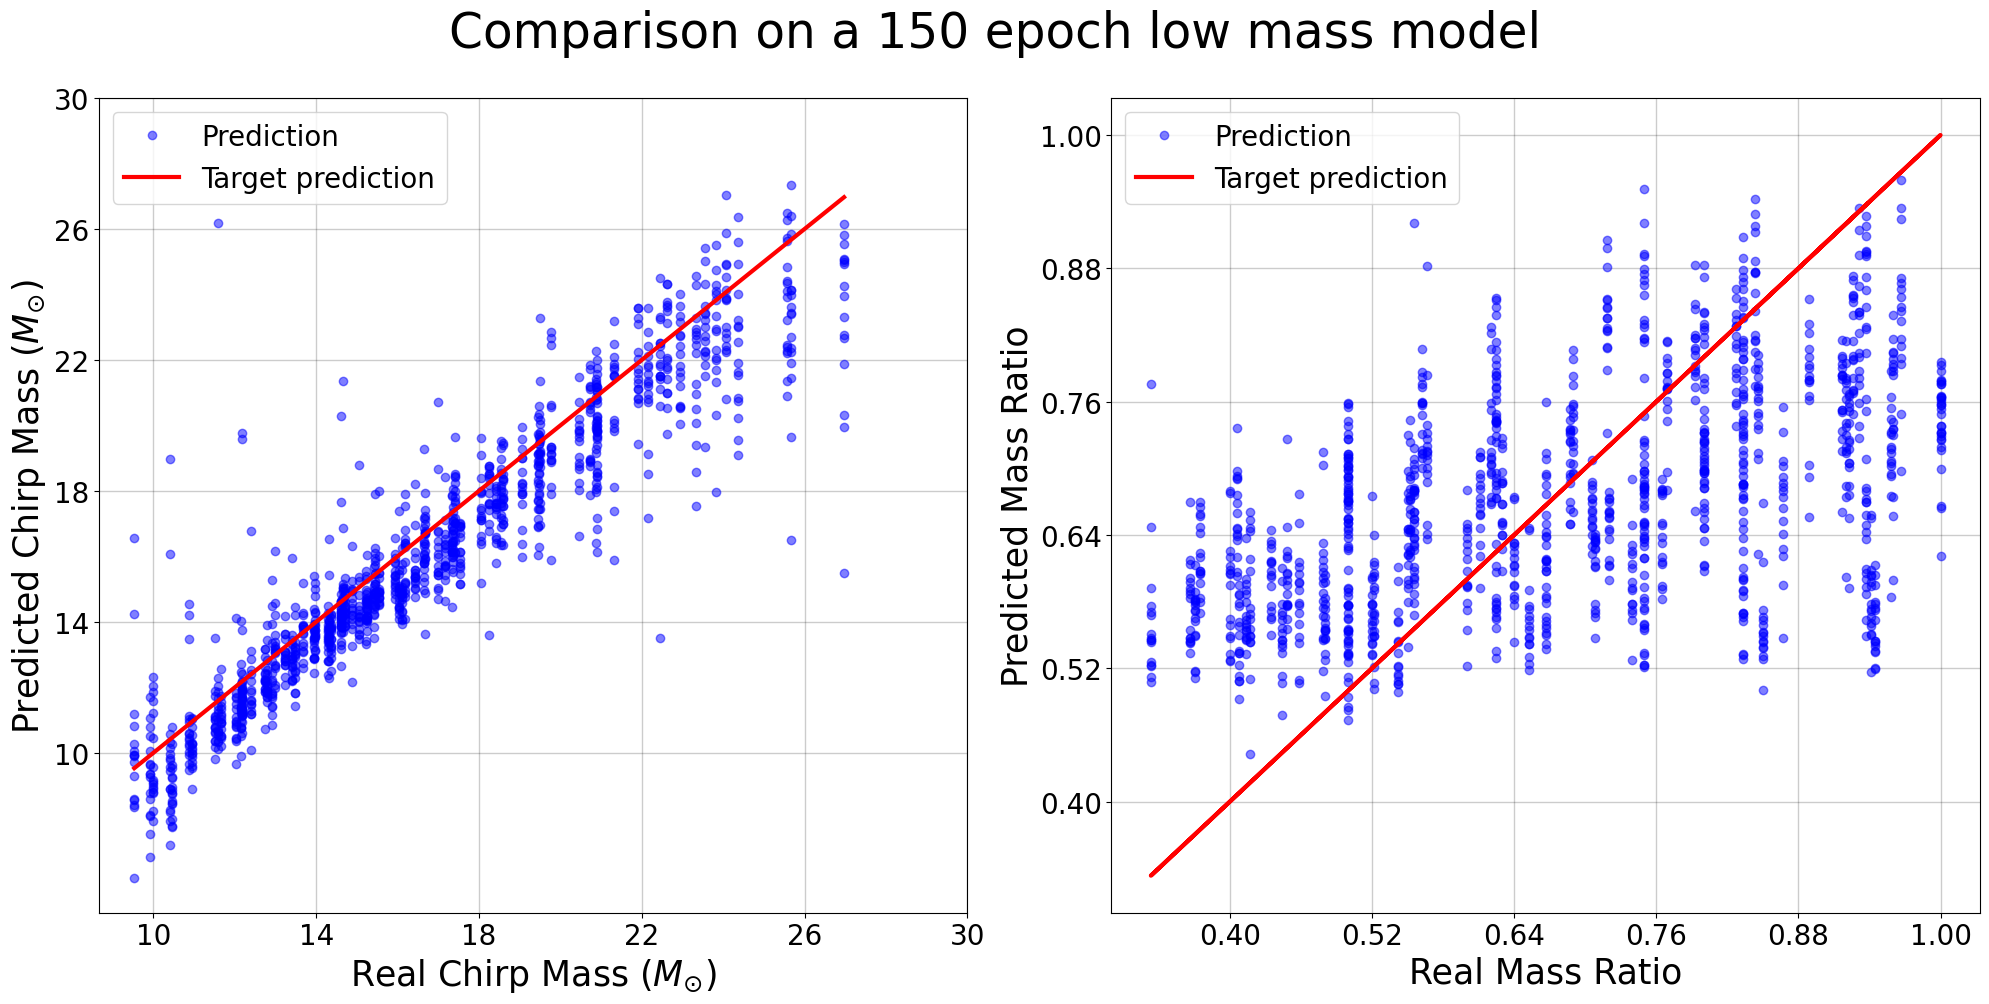

In [8]:
plot_regression(true_M, pred_M, true_q, pred_q, 
                title='Comparison on a 150 epoch low mass model', 
                ticks_M=np.linspace(10, 30, 6), ticks_q=np.linspace(0.4,1.0,6),
                save_path=f'plots/{mass_range}_regression.png')

In [9]:
## COMPUTE RELATIVE ERROR

a = np.reshape(pred_M,(1,len(pred_M)))
b = np.reshape(true_M,(1,len(true_M)))
rel_err_chirp_low = np.squeeze(((a - b) / b) * 100)

a = np.reshape(pred_q,(1,len(pred_q)))
b = np.reshape(true_q,(1,len(true_q)))
rel_err_ratio_low = np.squeeze(((a - b) / b) * 100)

df = pd.DataFrame({
    "Mass Range": [mass_range] * len(rel_err_chirp_low),
    "Relative Error Chirp Mass (%)": rel_err_chirp_low,
    "Relative Error Mass Ratio (%)": rel_err_ratio_low
})

df.to_csv("relative_errors.csv", index=False)

## Mid mass I

In [9]:
mass_range = "CNN_mid_mass_I"

train_path = f"{root_dir}/{mass_range}_train.npz"
test_path = f"{root_dir}/{mass_range}_test.npz"

# load the data 
with np.load(train_path, allow_pickle=True) as data:
    X = data["X"]
    y = data["y"]

mask = y[:,0] == 1 
X, y= X[mask], y[mask]

X_train, X_val, y_train, y_val = split_train_val(X, y, val_size=0.2)

with np.load(test_path, allow_pickle=True) as data:
    X_test = data["X"]
    y_test = data["y"]

mask = y_test[:,0] == 1
X_test, y_test= X_test[mask], y_test[mask]

# create the dataset 
batch_size = 64

train_dataset, train_scaler = make_dataset(X_train, y_train, classification=False, batch_size=batch_size)
val_dataset, val_scaler = make_dataset(X_val, y_val, classification=False, batch_size=batch_size)
test_dataset, test_scaler = make_dataset(X_test, y_test, classification=False, batch_size=batch_size, shuffle=False)

In [11]:
model = build_model(reg_rate=5e-4, drop_rate=0.3)

total_steps = 5808 // 128 * 150  # Assuming 5808 training samples, batch size 64, for 50 epochs
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=5e-5,
    decay_steps=total_steps,
    alpha=1e-6
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=5.0), 
              loss=tf.keras.losses.MeanSquaredError(),               
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

/home/alberto_sinigaglia/anaconda3/envs/gaia/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [10]:
model_path = f"reg_models/{mass_range}_best_model.keras"
logger_path = f"reg_models/training_log_{mass_range}.csv"

'''
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=model_path, 
        monitor="val_loss",
        mode="min",
        save_best_only=True,
        verbose=1,
    ),
    
    tf.keras.callbacks.CSVLogger(
        filename=logger_path,
        append=False,
    )
]

history = model.fit(
    x=train_dataset,
    validation_data=val_dataset,
    epochs=150,
    callbacks=callbacks,
    verbose=1,
)
'''

'\ncallbacks = [\n    tf.keras.callbacks.ModelCheckpoint(\n        filepath=model_path, \n        monitor="val_loss",\n        mode="min",\n        save_best_only=True,\n        verbose=1,\n    ),\n    \n    tf.keras.callbacks.CSVLogger(\n        filename=logger_path,\n        append=False,\n    )\n]\n\nhistory = model.fit(\n    x=train_dataset,\n    validation_data=val_dataset,\n    epochs=150,\n    callbacks=callbacks,\n    verbose=1,\n)\n'

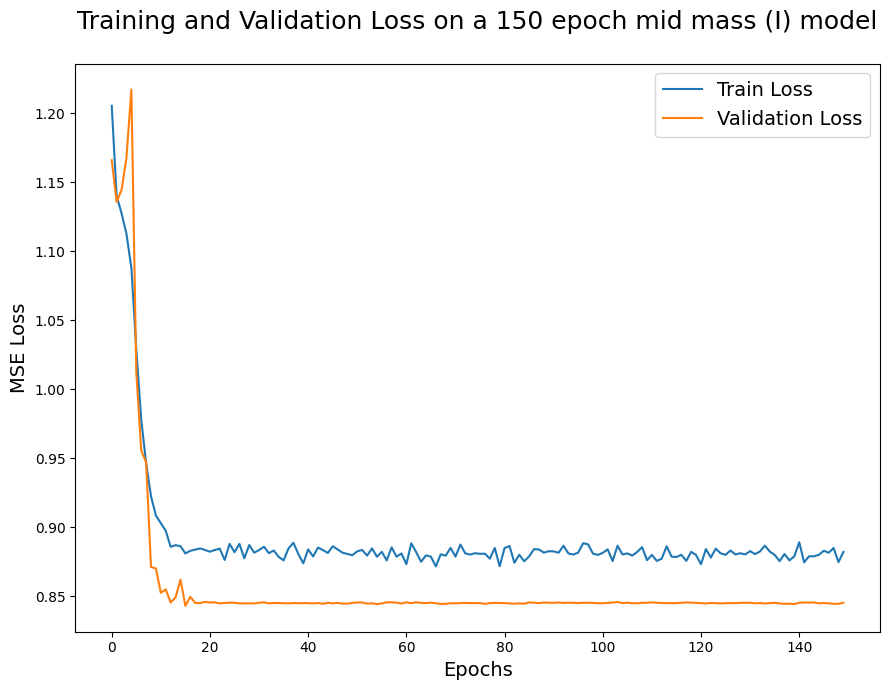

In [17]:
logger = pd.read_csv(logger_path)
train_loss = logger['loss'].values
val_loss = logger['val_loss'].values

plt.figure(figsize=(9,7))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('MSE Loss', fontsize=14)

plt.title('Training and Validation Loss on a 150 epoch mid mass (I) model',
          fontsize=18, pad=25)

plt.legend(fontsize=14, loc='best')

plt.tight_layout()
plt.show()

In [11]:
model = tf.keras.models.load_model(model_path)
mse, rmse = model.evaluate(test_dataset)
y_pred = model.predict(X_test)
y_pred = test_scaler.inverse_transform(y_pred)

true_M = y_test[:,1].astype(np.float64)
pred_M = y_pred[:,0]
rmse_M = np.sqrt(np.mean((pred_M - true_M)**2))

true_q = y_test[:,2].astype(np.float64)
pred_q = y_pred[:,1]
rmse_q = np.sqrt(np.mean((pred_q - true_q)**2))

print(f"Test chirp mass RMSE: {rmse_M} \n Test mass ratio RMSE: {rmse_q}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.8907 - rmse: 0.8516
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Test chirp mass RMSE: 2.5745119959157776 
 Test mass ratio RMSE: 0.10003879675471905


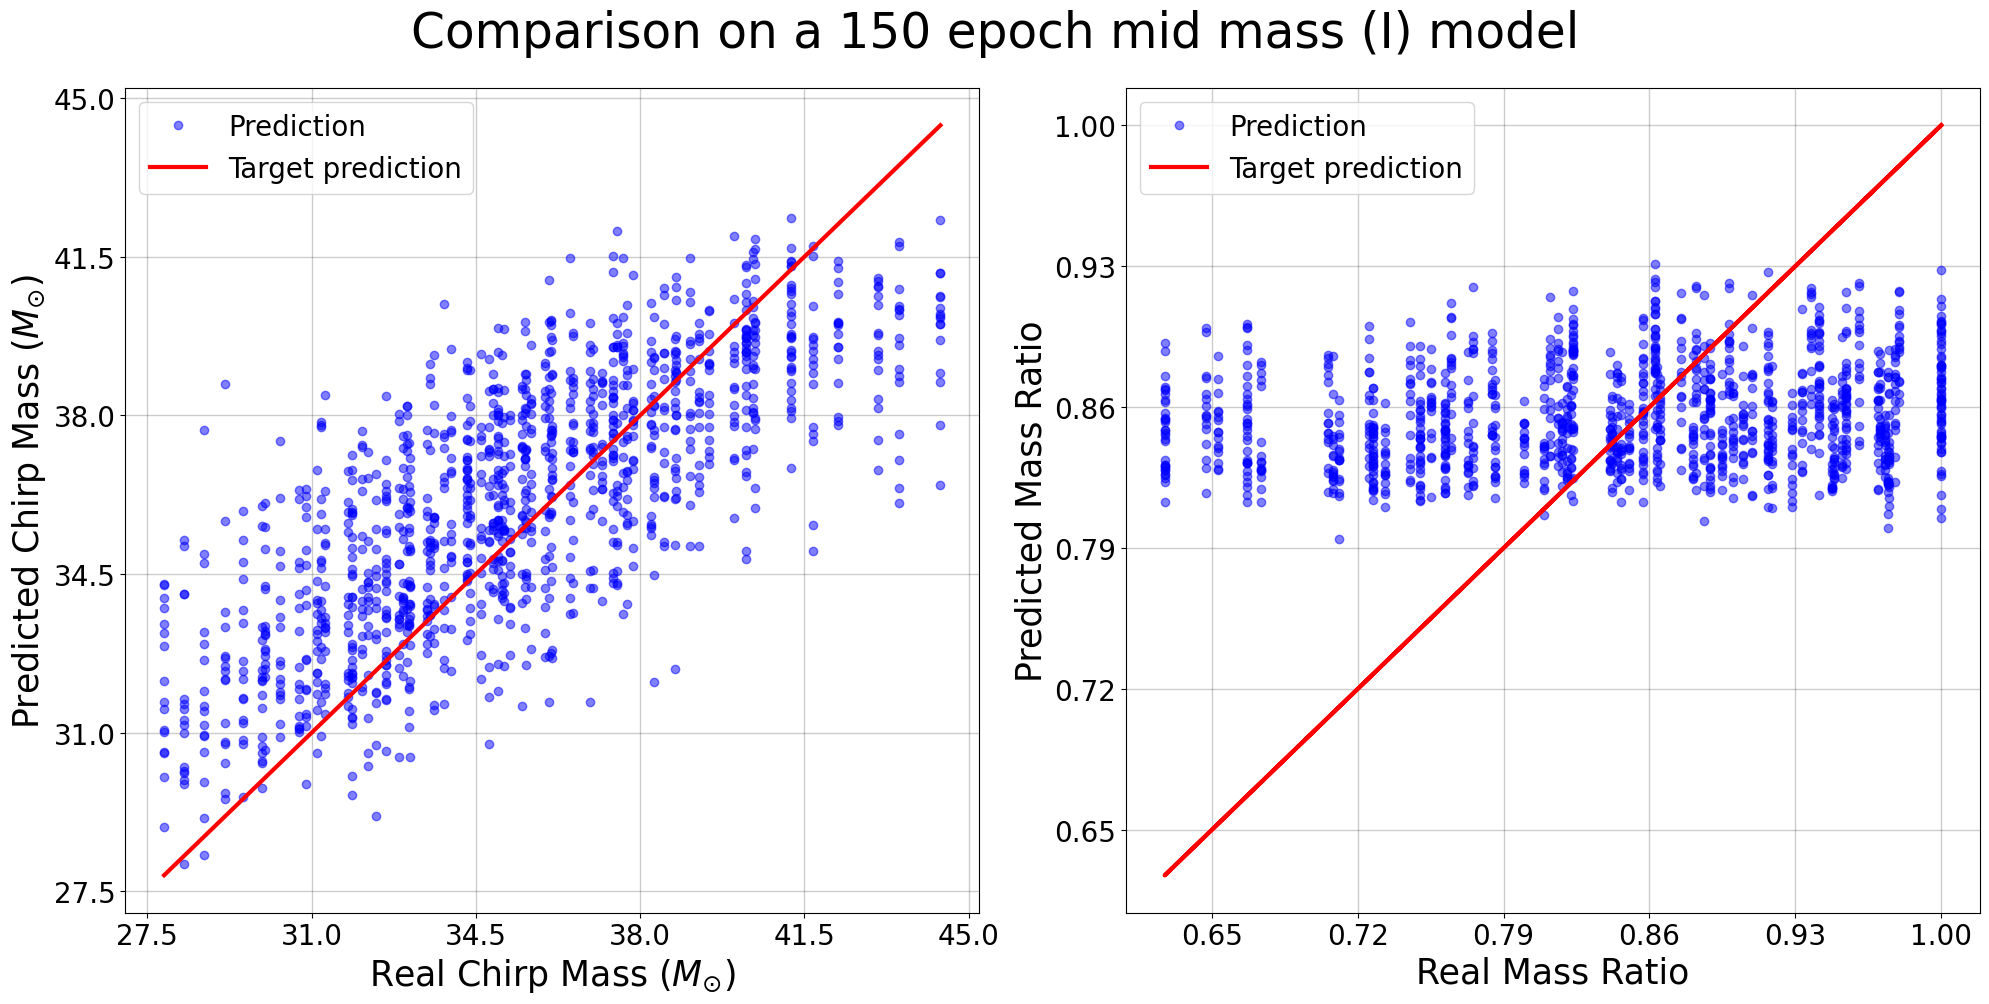

In [12]:
plot_regression(true_M, pred_M, true_q, pred_q, 
                title='Comparison on a 150 epoch mid mass (I) model', 
                ticks_M=np.linspace(27.5, 45, 6), ticks_q=np.linspace(0.65,1.0,6),
                save_path=f'plots/{mass_range}_regression.png')

In [14]:
## COMPUTE RELATIVE ERROR

a = np.reshape(pred_M,(1,len(pred_M)))
b = np.reshape(true_M,(1,len(true_M)))
rel_err_chirp_mid_I = np.squeeze(((a - b) / b) * 100)

a = np.reshape(pred_q,(1,len(pred_q)))
b = np.reshape(true_q,(1,len(true_q)))
rel_err_ratio_mid_I = np.squeeze(((a - b) / b) * 100)

df = pd.DataFrame({
    "Mass Range": [mass_range] * len(rel_err_chirp_mid_I),
    "Relative Error Chirp Mass (%)": rel_err_chirp_mid_I,
    "Relative Error Mass Ratio (%)": rel_err_ratio_mid_I
})

# Append to existing CSV (create it if it doesn't exist)
df.to_csv("relative_errors.csv", mode='a', index=False)

## Mid mass II

In [13]:
mass_range = "CNN_mid_mass_II"

train_path = f"{root_dir}/{mass_range}_train.npz"
test_path = f"{root_dir}/{mass_range}_test.npz"

# load the data 
with np.load(train_path, allow_pickle=True) as data:
    X = data["X"]
    y = data["y"]

mask = y[:,0] == 1 
X, y= X[mask], y[mask]

X_train, X_val, y_train, y_val = split_train_val(X, y, val_size=0.2)

with np.load(test_path, allow_pickle=True) as data:
    X_test = data["X"]
    y_test = data["y"]

mask = y_test[:,0] == 1
X_test, y_test= X_test[mask], y_test[mask]

# create the dataset 
batch_size = 64

train_dataset, train_scaler = make_dataset(X_train, y_train, classification=False, batch_size=batch_size)
val_dataset, val_scaler = make_dataset(X_val, y_val, classification=False, batch_size=batch_size)
test_dataset, test_scaler = make_dataset(X_test, y_test, classification=False, batch_size=batch_size, shuffle=False)

In [16]:
model = build_model(reg_rate=1e-3, drop_rate=0.3)

total_steps = 5808 // 128 * 150  # Assuming 5808 training samples, batch size 64, for 50 epochs
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=5e-5,
    decay_steps=total_steps,
    alpha=1e-6
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=5.0), 
              loss=tf.keras.losses.MeanSquaredError(),               
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

/home/alberto_sinigaglia/anaconda3/envs/gaia/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [14]:
model_path = f"reg_models/{mass_range}_best_model.keras"
logger_path = f"reg_models/training_log_{mass_range}.csv"

'''
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=model_path, 
        monitor="val_loss",
        mode="min",
        save_best_only=True,
        verbose=1,
    ),
    
    tf.keras.callbacks.CSVLogger(
        filename=logger_path,
        append=False,
    )
]

history = model.fit(
    x=train_dataset,
    validation_data=val_dataset,
    epochs=150,
    callbacks=callbacks,
    verbose=1,
)
'''

'\ncallbacks = [\n    tf.keras.callbacks.ModelCheckpoint(\n        filepath=model_path, \n        monitor="val_loss",\n        mode="min",\n        save_best_only=True,\n        verbose=1,\n    ),\n    \n    tf.keras.callbacks.CSVLogger(\n        filename=logger_path,\n        append=False,\n    )\n]\n\nhistory = model.fit(\n    x=train_dataset,\n    validation_data=val_dataset,\n    epochs=150,\n    callbacks=callbacks,\n    verbose=1,\n)\n'

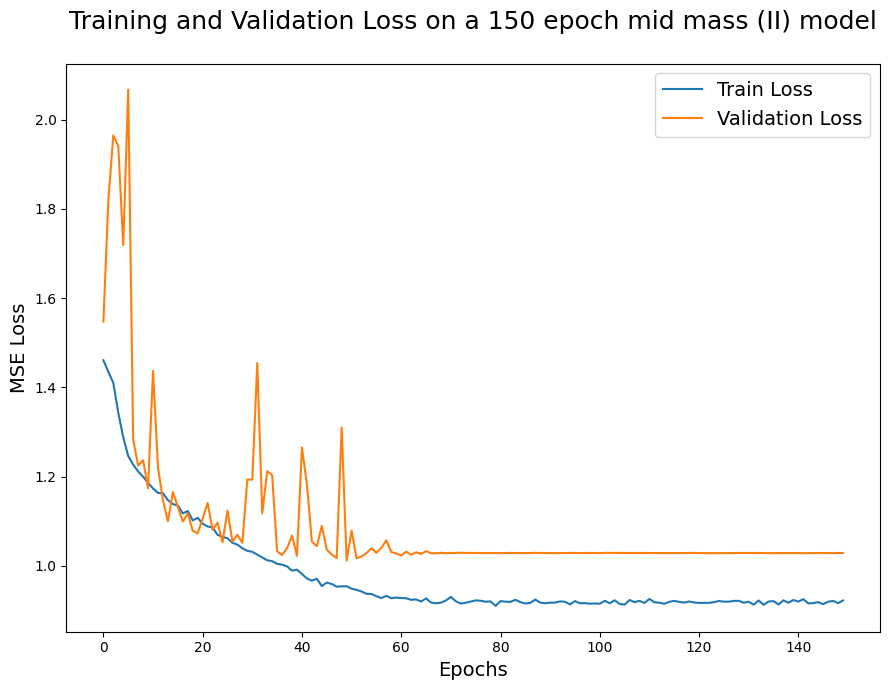

In [27]:
logger = pd.read_csv(logger_path)
train_loss = logger['loss'].values
val_loss = logger['val_loss'].values

plt.figure(figsize=(9,7))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('MSE Loss', fontsize=14)

plt.title('Training and Validation Loss on a 150 epoch mid mass (II) model',
          fontsize=18, pad=25)

plt.legend(fontsize=14, loc='best')

plt.tight_layout()
plt.show()

In [15]:
model = tf.keras.models.load_model(model_path)
mse, rmse = model.evaluate(test_dataset)
y_pred = model.predict(X_test)
y_pred = test_scaler.inverse_transform(y_pred)

true_M = y_test[:,1].astype(np.float64)
pred_M = y_pred[:,0]
rmse_M = np.sqrt(np.mean((pred_M - true_M)**2))

true_q = y_test[:,2].astype(np.float64)
pred_q = y_pred[:,1]
rmse_q = np.sqrt(np.mean((pred_q - true_q)**2))

print(f"Test chirp mass RMSE: {rmse_M} \n Test mass ratio RMSE: {rmse_q}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 1.0875 - rmse: 0.8729
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
Test chirp mass RMSE: 2.721548363456816 
 Test mass ratio RMSE: 0.06909238120512486


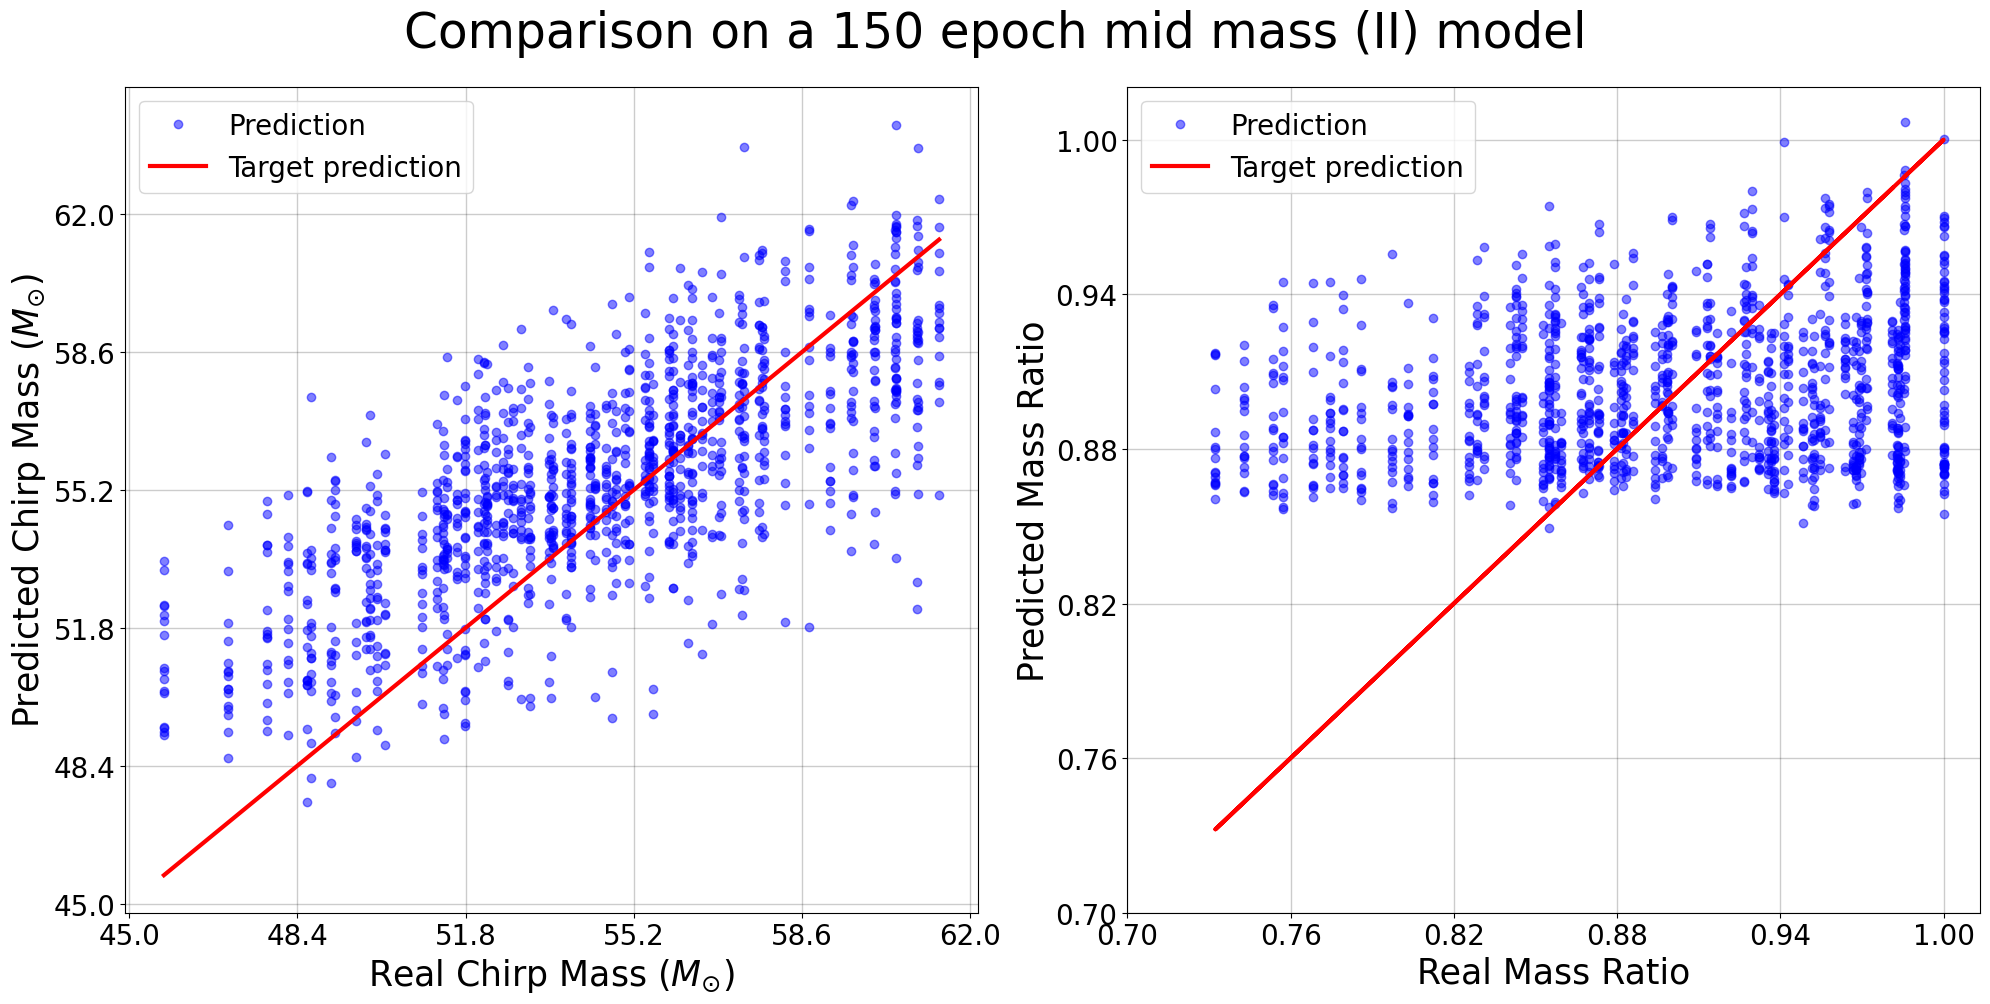

In [30]:
plot_regression(true_M, pred_M, true_q, pred_q, 
                title='Comparison on a 150 epoch mid mass (II) model', 
                ticks_M=np.linspace(45, 62, 6), ticks_q=np.linspace(0.70,1.0,6),
                save_path=f'plots/{mass_range}_regression.png')

In [19]:
## COMPUTE RELATIVE ERROR
a = np.reshape(pred_M,(1,len(pred_M)))
b = np.reshape(true_M,(1,len(true_M)))
rel_err_chirp_mid_II = np.squeeze(((a - b) / b) * 100)   

a = np.reshape(pred_q,(1,len(pred_q)))
b = np.reshape(true_q,(1,len(true_q)))
rel_err_ratio_mid_II = np.squeeze(((a - b) / b) * 100)

df = pd.DataFrame({
    "Mass Range": [mass_range] * len(rel_err_chirp_mid_II),
    "Relative Error Chirp Mass (%)": rel_err_chirp_mid_II,
    "Relative Error Mass Ratio (%)": rel_err_ratio_mid_II
})

# Append to existing CSV (create it if it doesn't exist)
df.to_csv("relative_errors.csv", mode='a', index=False)

## High mass

In [16]:
mass_range = "CNN_high_mass"

train_path = f"{root_dir}/{mass_range}_train.npz"
test_path = f"{root_dir}/{mass_range}_test.npz"

# load the data 
with np.load(train_path, allow_pickle=True) as data:
    X = data["X"]
    y = data["y"]

mask = y[:,0] == 1 
X, y= X[mask], y[mask]

X_train, X_val, y_train, y_val = split_train_val(X, y, val_size=0.2)

with np.load(test_path, allow_pickle=True) as data:
    X_test = data["X"]
    y_test = data["y"]

mask = y_test[:,0] == 1
X_test, y_test= X_test[mask], y_test[mask]

# create the dataset 
batch_size = 64

train_dataset, train_scaler = make_dataset(X_train, y_train, classification=False, batch_size=batch_size)
val_dataset, val_scaler = make_dataset(X_val, y_val, classification=False, batch_size=batch_size)
test_dataset, test_scaler = make_dataset(X_test, y_test, classification=False, batch_size=batch_size, shuffle=False)

In [21]:
model = build_model(reg_rate=1e-3, drop_rate=0.3)

total_steps = 5808 // 128 * 150  # Assuming 5808 training samples, batch size 64, for 50 epochs
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=5e-5,
    decay_steps=total_steps,
    alpha=1e-6
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=5.0), 
              loss=tf.keras.losses.MeanSquaredError(),               
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

/home/alberto_sinigaglia/anaconda3/envs/gaia/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [17]:
model_path = f"reg_models/{mass_range}_best_model.keras"
logger_path = f"reg_models/training_log_{mass_range}.csv"

'''
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=model_path, 
        monitor="val_loss",
        mode="min",
        save_best_only=True,
        verbose=1,
    ),
    
    tf.keras.callbacks.CSVLogger(
        filename=logger_path,
        append=False,
    )
]

history = model.fit(
    x=train_dataset,
    validation_data=val_dataset,
    epochs=150,
    callbacks=callbacks,
    verbose=1,
)
'''

'\ncallbacks = [\n    tf.keras.callbacks.ModelCheckpoint(\n        filepath=model_path, \n        monitor="val_loss",\n        mode="min",\n        save_best_only=True,\n        verbose=1,\n    ),\n    \n    tf.keras.callbacks.CSVLogger(\n        filename=logger_path,\n        append=False,\n    )\n]\n\nhistory = model.fit(\n    x=train_dataset,\n    validation_data=val_dataset,\n    epochs=150,\n    callbacks=callbacks,\n    verbose=1,\n)\n'

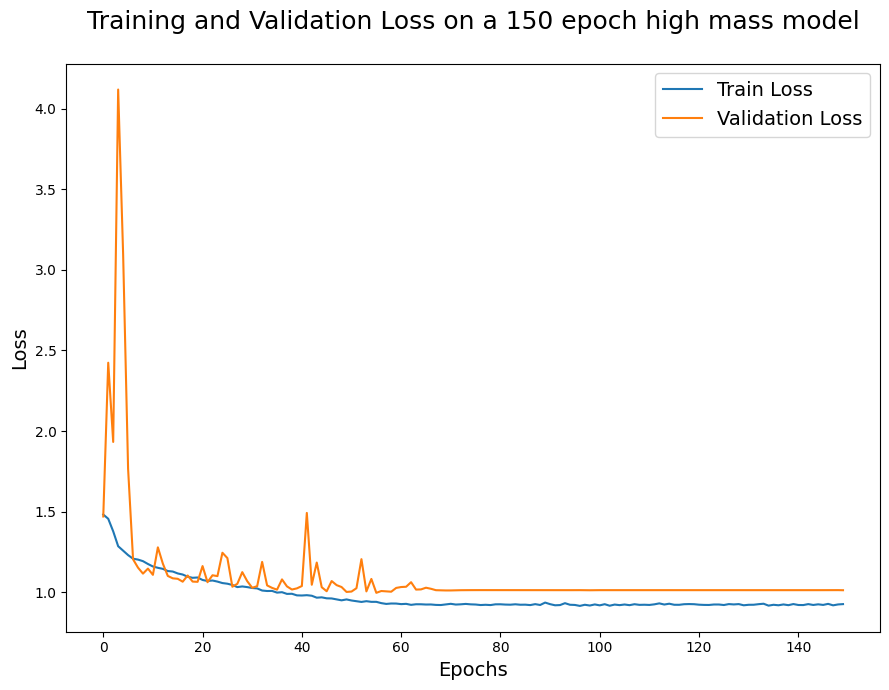

In [23]:
logger = pd.read_csv(logger_path)
train_loss = logger['loss'].values
val_loss = logger['val_loss'].values

plt.figure(figsize=(9,7))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.title('Training and Validation Loss on a 150 epoch high mass model',
          fontsize=18, pad=25)

plt.legend(fontsize=14, loc='best')

plt.tight_layout()
plt.show()

In [19]:
model = tf.keras.models.load_model(model_path)
mse, rmse = model.evaluate(test_dataset)
y_pred = model.predict(X_test)
y_pred = test_scaler.inverse_transform(y_pred)

true_M = y_test[:,1].astype(np.float64)
pred_M = y_pred[:,0]
rmse_M = np.sqrt(np.mean((pred_M - true_M)**2))

true_q = y_test[:,2].astype(np.float64)
pred_q = y_pred[:,1]
rmse_q = np.sqrt(np.mean((pred_q - true_q)**2))

print(f"Test chirp mass RMSE: {rmse_M} \n Test mass ratio RMSE: {rmse_q}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 1.0706 - rmse: 0.8608
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Test chirp mass RMSE: 2.707229771317894 
 Test mass ratio RMSE: 0.05968926467354665


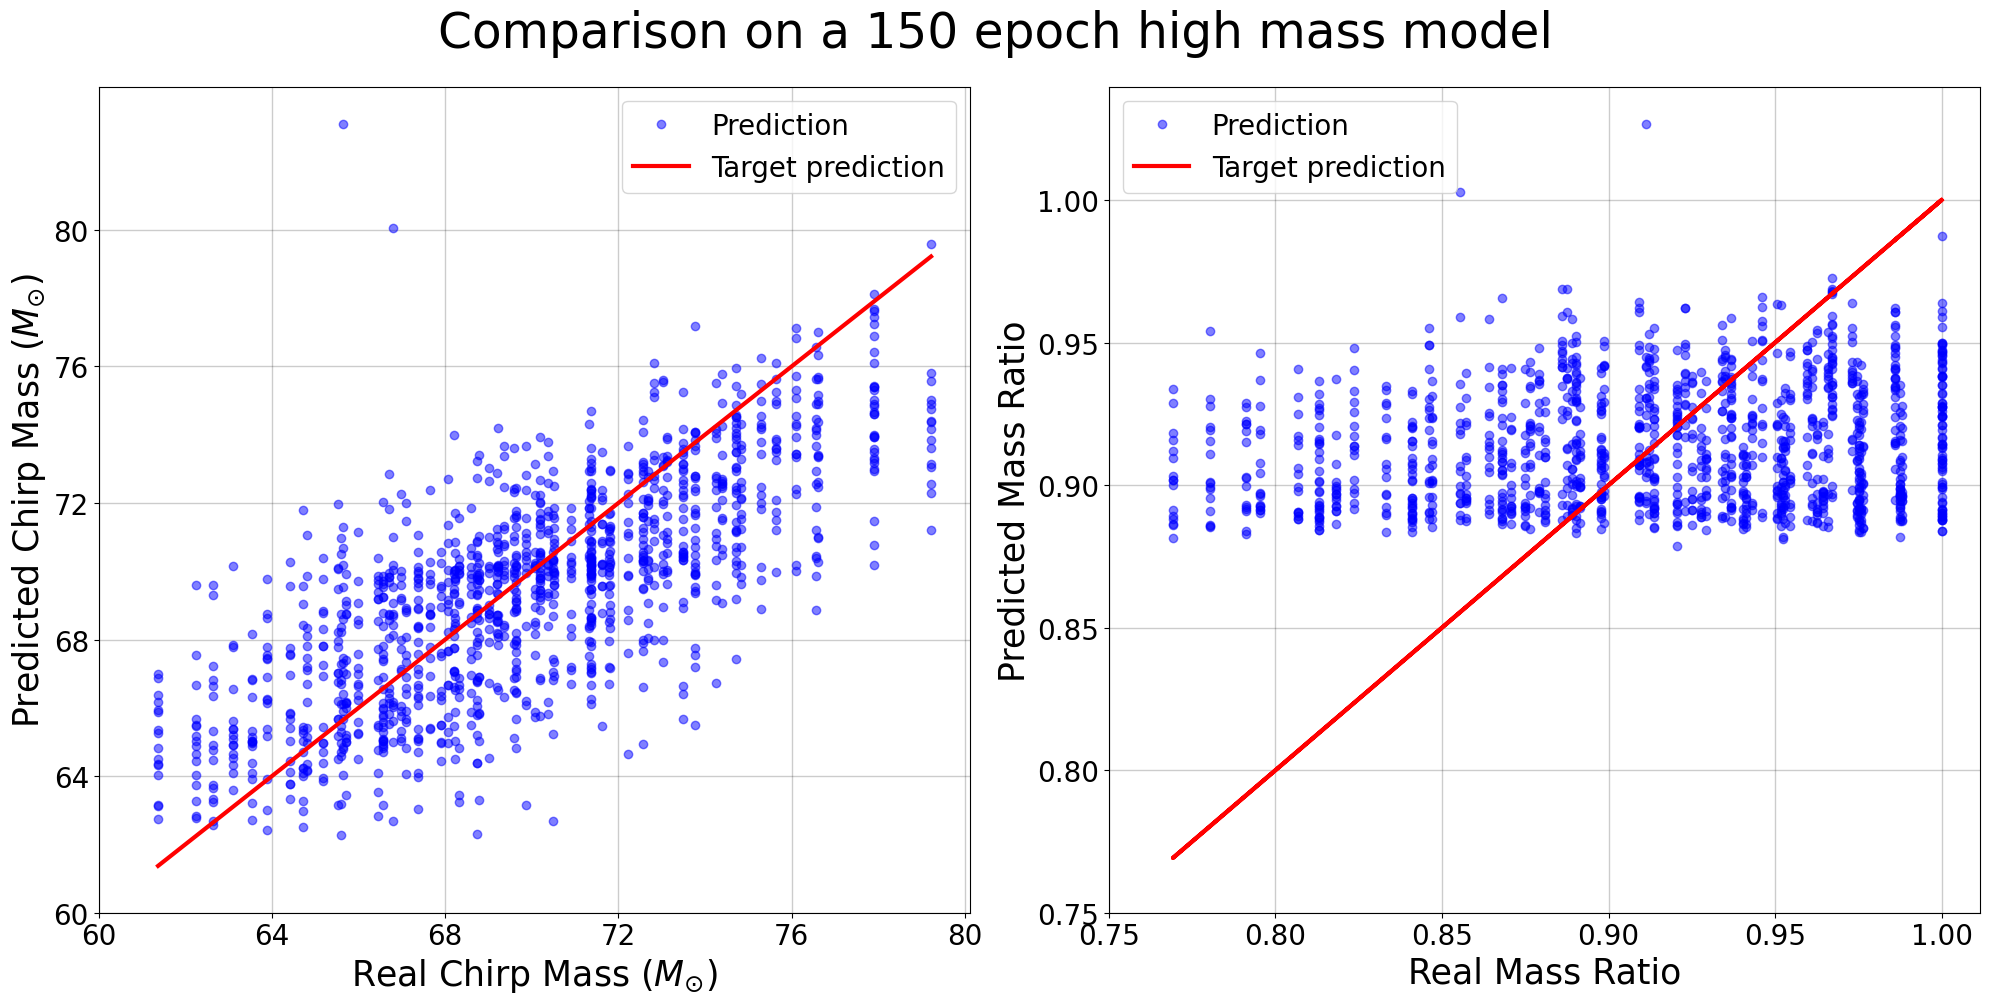

In [20]:
plot_regression(true_M, pred_M, true_q, pred_q, 
                title='Comparison on a 150 epoch high mass model', 
                ticks_M=np.linspace(60, 80, 6), ticks_q=np.linspace(0.75,1.0,6),
                save_path=f'plots/{mass_range}_regression.png')

In [25]:
## COMPUTE RELATIVE ERROR
a = np.reshape(pred_M,(1,len(pred_M)))
b = np.reshape(true_M,(1,len(true_M)))
rel_err_chirp_high = np.squeeze(((a - b) / b) * 100)   

a = np.reshape(pred_q,(1,len(pred_q)))
b = np.reshape(true_q,(1,len(true_q)))
rel_err_ratio_high = np.squeeze(((a - b) / b) * 100)

df = pd.DataFrame({
    "Mass Range": [mass_range] * len(rel_err_chirp_high),
    "Relative Error Chirp Mass (%)": rel_err_chirp_high,
    "Relative Error Mass Ratio (%)": rel_err_ratio_high
})

# Append to existing CSV (create it if it doesn't exist)
df.to_csv("relative_errors.csv", mode='a', index=False)

## Relative errors 

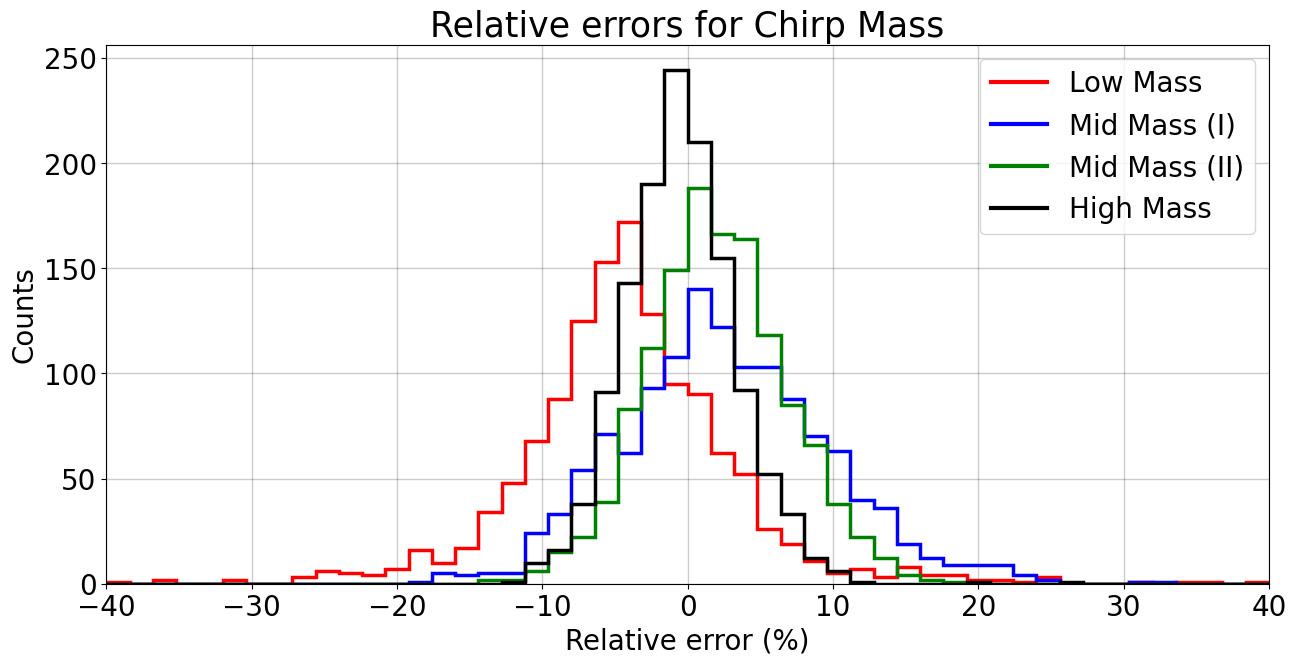

In [36]:
# Chirp

df = pd.read_csv("relative_errors.csv")
rel_err_chirp_low = df[df["Mass Range"] == "CNN_low_mass"]["Relative Error Chirp Mass (%)"].values.astype(np.float64)
rel_err_chirp_mid_I = df[df["Mass Range"] == "CNN_mid_mass_I"]["Relative Error Chirp Mass (%)"].values.astype(np.float64)
rel_err_chirp_mid_II = df[df["Mass Range"] == "CNN_mid_mass_II"]["Relative Error Chirp Mass (%)"].values.astype(np.float64)
rel_err_chirp_high = df[df["Mass Range"] == "CNN_high_mass"]["Relative Error Chirp Mass (%)"].values.astype(np.float64)

fig = plt.figure(figsize=(15,7)) 
plt.hist(rel_err_chirp_low, bins=50, histtype='step', color='red', linewidth=2.5, label='Low Mass', range=(-40,40))
plt.hist(rel_err_chirp_mid_I, bins=50, histtype='step', color='blue', linewidth=2.5, label='Mid Mass (I)', range=(-40,40))
plt.hist(rel_err_chirp_mid_II, bins=50, histtype='step', color='green', linewidth=2.5, label='Mid Mass (II)', range=(-40,40))
plt.hist(rel_err_chirp_high, bins=50, histtype='step', color='black', linewidth=2.5, label='High Mass', range=(-40,40))

labels = ['Low Mass', 'Mid Mass (I)', 'Mid Mass (II)', 'High Mass']
handle1 = matplotlib.lines.Line2D([], [], c='red')
handle2 = matplotlib.lines.Line2D([], [], c='blue')
handle3 = matplotlib.lines.Line2D([], [], c='green')
handle4 = matplotlib.lines.Line2D([], [], c='black')

leg = plt.legend(handles=[handle1, handle2, handle3, handle4],labels=labels, loc='upper right', prop={'size':20})

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3.0)

plt.grid(linewidth=1, color='black', alpha=0.2)

plt.xlim(-40,40)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.ylabel('Counts', fontsize=20)
plt.xlabel('Relative error (%)', fontsize=20)
plt.yscale("linear")
plt.title("Relative errors for Chirp Mass", fontsize=25)
plt.show()
plt.close(fig)

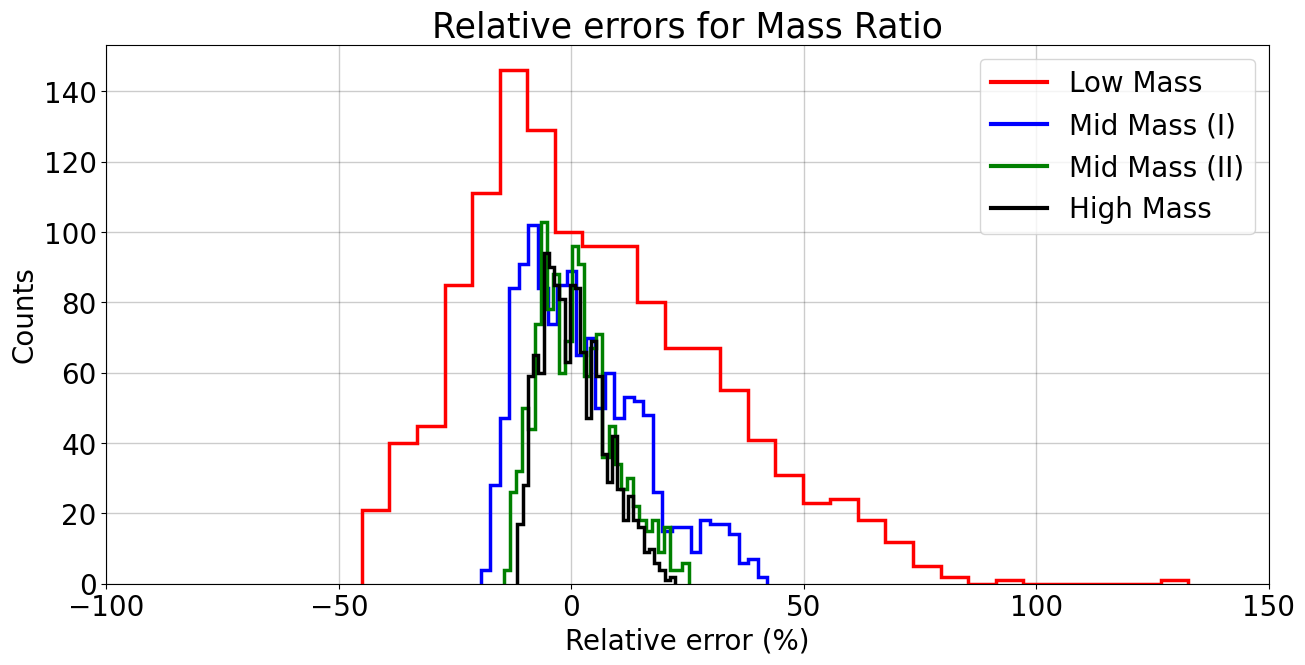

In [43]:
# Ratio
df = pd.read_csv("relative_errors.csv")
rel_err_chirp_low = df[df["Mass Range"] == "CNN_low_mass"]["Relative Error Mass Ratio (%)"].values.astype(np.float64)
rel_err_chirp_mid_I = df[df["Mass Range"] == "CNN_mid_mass_I"]["Relative Error Mass Ratio (%)"].values.astype(np.float64)
rel_err_chirp_mid_II = df[df["Mass Range"] == "CNN_mid_mass_II"]["Relative Error Mass Ratio (%)"].values.astype(np.float64)
rel_err_chirp_high = df[df["Mass Range"] == "CNN_high_mass"]["Relative Error Mass Ratio (%)"].values.astype(np.float64)

fig = plt.figure(figsize=(15,7)) 
plt.hist(rel_err_ratio_low, bins=30, histtype='step', color='red', linewidth=2.5, label='Low Mass')
plt.hist(rel_err_ratio_mid_I, bins=30, histtype='step', color='blue', linewidth=2.5, label='Mid Mass (I)')
plt.hist(rel_err_ratio_mid_II, bins=30, histtype='step', color='green', linewidth=2.5, label='Mid Mass (II)')
plt.hist(rel_err_ratio_high, bins=30, histtype='step', color='black', linewidth=2.5, label='High Mass')


labels = ['Low Mass', 'Mid Mass (I)', 'Mid Mass (II)', 'High Mass']
handle1 = matplotlib.lines.Line2D([], [], c='red')
handle2 = matplotlib.lines.Line2D([], [], c='blue')
handle3 = matplotlib.lines.Line2D([], [], c='green')
handle4 = matplotlib.lines.Line2D([], [], c='black')

leg = plt.legend(handles=[handle1, handle2, handle3, handle4],labels=labels, loc='upper right', prop={'size':20})

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3.0)

plt.grid(linewidth=1, color='black', alpha=0.2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlim(-100,150)

plt.ylabel('Counts', fontsize=20)
plt.xlabel('Relative error (%)', fontsize=20)
plt.yscale("linear")
plt.title("Relative errors for Mass Ratio", fontsize=25)
plt.show()
plt.close(fig)